# End-to-End Multiclass Image Classification Example (Managed Spot Training)

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
3. [Training the ResNet model](#Training-the-ResNet-model)
  1. [Spot Configuration](#Spot-Configuration)
  2. [Reviewing Spot Savings](#Reviewing-Spot-Savings)
4. [Deploy The Model](#Deploy-the-model)
  1. [Create model](#Create-model)
  2. [Batch transform](#Batch-transform)
  3. [Realtime inference](#Realtime-inference)
    1. [Create endpoint configuration](#Create-endpoint-configuration) 
    2. [Create endpoint](#Create-endpoint) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)


## Introduction

Welcome to our end-to-end example of distributed image classification algorithm. In this demo, we will use the Amazon sagemaker image classification algorithm to train on the [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import boto3
import re
import uuid
import json
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
print(training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:1
CPU times: user 825 ms, sys: 80.1 ms, total: 906 ms
Wall time: 1.36 s


### S3 Bucket Configuration

We will be creating an S3 bucket and applying permissions to allow SageMaker to access data stored within this bucket for the purposes of training our models. 

In [2]:
# Define Variables and get Execution Role

bucket = 'sagemaker-spot-{}'.format(uuid.uuid4())
prefix = 'sagemaker/spot'

role = get_execution_role()

s3 = boto3.client('s3')

print(role)

arn:aws:iam::174570359254:role/service-role/AmazonSageMaker-ExecutionRole-20191105T081631


In [3]:
# Get Current Region

my_session = boto3.session.Session()
region = my_session.region_name
print(region)

us-west-2


In [4]:
# Create Bucket

response = s3.create_bucket(
    Bucket=bucket,
     CreateBucketConfiguration={
            'LocationConstraint': region
        },
)
print(response)

{'ResponseMetadata': {'RequestId': 'C7C14CB416928E94', 'HostId': 'dkh7Ms+hpdBAT3w/P3VSCR8FuPTXEkasutvdzFCfl78a2hGIdnEKF3laXHGpD79uA4BcwBMAXyU=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'dkh7Ms+hpdBAT3w/P3VSCR8FuPTXEkasutvdzFCfl78a2hGIdnEKF3laXHGpD79uA4BcwBMAXyU=', 'x-amz-request-id': 'C7C14CB416928E94', 'date': 'Wed, 20 Nov 2019 20:21:53 GMT', 'location': 'http://sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8.s3.amazonaws.com/', 'content-length': '0', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'Location': 'http://sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8.s3.amazonaws.com/'}


In [5]:
# Set Policy

# Create the bucket policy
bucket_policy = {
    'Version': '2012-10-17',
    'Statement': [{
        'Sid': 'AddPerm',
        'Effect': 'Allow',
        'Principal': {
            'AWS': '{}'.format(role)
        },
        'Action': ['s3:GetObject'],
        'Resource': "arn:aws:s3:::%s/*" % bucket
    }]
}

print(bucket_policy)
# Convert the policy to a JSON string
bucket_policy = json.dumps(bucket_policy)

# Set the new policy on the given bucket
s3.put_bucket_policy(Bucket=bucket, Policy=bucket_policy)

{'Version': '2012-10-17', 'Statement': [{'Sid': 'AddPerm', 'Effect': 'Allow', 'Principal': {'AWS': 'arn:aws:iam::174570359254:role/service-role/AmazonSageMaker-ExecutionRole-20191105T081631'}, 'Action': ['s3:GetObject'], 'Resource': 'arn:aws:s3:::sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8/*'}]}


{'ResponseMetadata': {'RequestId': 'B812001B51DBF043',
  'HostId': 'SX2WRXa+FVwDzLLFAIMKZczxcHoCrIKPmCsd94sPtJ0IdgnizpNsZPqOoTt6CcibjdDe6ysv3ro=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'SX2WRXa+FVwDzLLFAIMKZczxcHoCrIKPmCsd94sPtJ0IdgnizpNsZPqOoTt6CcibjdDe6ysv3ro=',
   'x-amz-request-id': 'B812001B51DBF043',
   'date': 'Wed, 20 Nov 2019 20:21:55 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [6]:
prefix = 'sagemaker/SPOT-image-classification-full-training'

# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

print(bucket_path)

https://s3-us-west-2.amazonaws.com/sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8


### Data preparation
Download the data and transfer to S3 for use in training.

In [7]:
import os 
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
s3_train_key = "{}/train".format(prefix)
s3_validation_key = "{}/validation".format(prefix)
s3_train = 's3://{}/{}/'.format(bucket, s3_train_key)
s3_validation = 's3://{}/{}/'.format(bucket, s3_validation_key)

download('http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec')
upload_to_s3(s3_train_key, 'caltech-256-60-train.rec')
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec')
upload_to_s3(s3_validation_key, 'caltech-256-60-val.rec')

## Training the ResNet model

In this demo, we are using [Caltech-256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) dataset, which contains 30608 images of 256 objects. For the training and validation data, we follow the splitting scheme in this MXNet [example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/data/caltech256.sh). In particular, it randomly selects 60 images per class for training, and uses the remaining data for validation. The algorithm takes `RecordIO` file as input. The user can also provide the image files as input, which will be converted into `RecordIO` format using MXNet's [im2rec](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) tool. It takes around 50 seconds to converted the entire Caltech-256 dataset (~1.2GB) on a p2.xlarge instance. However, for this demo, we will use record io format. 

Once we have the data available in the correct format for training, the next step is to actually train the model using the data. After setting training parameters, we kick off training, and poll for status until training is completed.

## Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "rec" or "lst" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 101 in this samples but other values such as 50, 152 can be used. 
* **num_training_samples**: This is the total number of training samples. It is set to 15420 for caltech dataset with the current split
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 10 to 12 minutes per epoch on a p2.xlarge machine. The network typically converges after 10 epochs. However, to save the training time, we set the epochs to 2 but please keep in mind that it may not be  sufficient to generate a good model. 

In [8]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = "18" 
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
# for caltech it is 15420
num_training_samples = "15420"
# specify the number of output classes
num_classes = "257"
# batch size for training
mini_batch_size =  "64"
# number of epochs
epochs = "2"
# learning rate
learning_rate = "0.01"

# Training
Run the training using Amazon sagemaker CreateTrainingJob API

In [9]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name = 'SPOT-imageclassification' + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
    },
    "EnableManagedSpotTraining": True,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600,
        "MaxWaitTimeInSeconds": 3600
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: SPOT-imageclassification-2019-11-20-20-23-08

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8/sagemaker/SPOT-image-classification-full-training/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 6.38 ms, sys: 0 ns, total: 6.38 ms
Wall time: 6.24 ms


### Spot Configuration

Since we want to leverage Spot Instances for our training job, there are a few configuration parameters we need to pass when we create our SageMaker Training Job.

* EnableManagedSpotTraining - Specifies whether to use SageMaker Managed Spot instances for training. If enabled then the StoppingCondition/MaxWaitTimeInSeconds arg should also be set.

* StoppingCondition/MaxWaitTimeInSeconds - Timeout in seconds waiting for spot training instances (default: None). After this amount of time Amazon SageMaker will stop waiting for Spot instances to become available

* StoppingCondition/MaxRuntimeInSeconds - Timeout in seconds for training (default: 24 * 60 * 60). After this amount of time Amazon SageMaker terminates the job regardless of its current status.

The relevant JSON keys and values are as follows:
```
    "EnableManagedSpotTraining": True,
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600,
        "MaxWaitTimeInSeconds": 3600
    }
```

You can learn more about these and other configuration options here: https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html

In [10]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [11]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


If you see the message,

> `Training job ended with status: Completed`

then that means training successfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

### Reviewing Spot Savings

By leveraging Managed Spot Training for SageMaker we can use EC2 Spot Instances for our training jobs, and take advantage of significant savings. 

You can calculate the savings from using managed spot training using the formula (1 - BillableTimeInSeconds / TrainingTimeInSeconds) * 100. For example, if BillableTimeInSeconds is 100 and TrainingTimeInSeconds is 500, the savings is 80%.

In [13]:
job_details = sagemaker.describe_training_job(TrainingJobName=job_name)

billable_time = job_details['BillableTimeInSeconds']
training_time = job_details['TrainingTimeInSeconds']

print("Managed Spot Instance Training Savings: {:.1%}".format(1 - billable_time / training_time))

Managed Spot Instance Training Savings: 66.7%


# Deploy The Model

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Batch Transform](#BatchTransform) - Create a transform job to perform batch inference.
1. [Host the model for realtime inference](#HostTheModel) - Create an inference endpoint and perform realtime inference.

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create a Batch Transform Job or an Endpoint Configuration.

In [15]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="SPOT-full-image-classification-model" + time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

SPOT-full-image-classification-model-2019-11-20-20-35-48
s3://sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8/sagemaker/SPOT-image-classification-full-training/output/SPOT-imageclassification-2019-11-20-20-23-08/output/model.tar.gz
arn:aws:sagemaker:us-west-2:174570359254:model/spot-full-image-classification-model-2019-11-20-20-35-48
CPU times: user 70.4 ms, sys: 0 ns, total: 70.4 ms
Wall time: 338 ms


### Batch transform

We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

#### Download test data

In [16]:
# Download images under /008.bathtub
!wget -r -np -nH --cut-dirs=2 -P /tmp/ -R "index.html*" http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/


--2019-11-20 20:36:01--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32675 (32K) [text/html]
Saving to: ‘/tmp/images/008.bathtub/index.html’

images/008.bathtub/ 100%[===================>]  31.91K  --.-KB/s    in 0s      

2019-11-20 20:36:01 (66.6 MB/s) - ‘/tmp/images/008.bathtub/index.html’ saved [32675/32675]

Loading robots.txt; please ignore errors.
--2019-11-20 20:36:01--  http://www.vision.caltech.edu/robots.txt
Reusing existing connection to www.vision.caltech.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 1327 (1.3K) [text/plain]
Saving to: ‘/tmp/robots.txt’

robots.txt          100%[===================>]   1.30K  --.-KB/s    in 0s      

2019-11-20 20:36:01 (134 MB/s) - ‘/tmp/robots.txt’ saved [1327/1327]

Remo

In [17]:
batch_input = 's3://{}/image-classification-full-training/test/'.format(bucket)
test_images = '/tmp/images/008.bathtub'

!aws s3 cp $test_images $batch_input --recursive --quiet 

In [18]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name = "SPOT-image-classification-model" + timestamp
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(s3_validation))

Transform job name: image-classification-model-2019-11-20-20-36-59

Input Data Location: s3://sagemaker-spot-0adb59bb-1546-455e-9d8e-3c94a5c265e8/sagemaker/SPOT-image-classification-full-training/validation/


In [19]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

Created Transform job with name:  image-classification-model-2019-11-20-20-36-59
Transform job ended with status: Completed


After the job completes, let's inspect the prediction results. The accuracy may not be quite good because we set the epochs to 2 during training which may not be sufficient to train a good model. 

In [20]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:10]]

Sample inputs: ['image-classification-full-training/test/008_0001.jpg', 'image-classification-full-training/test/008_0002.jpg']
Sample output: ['image-classification-model-2019-11-20-20-36-59/output/008_0001.jpg.out', 'image-classification-model-2019-11-20-20-36-59/output/008_0002.jpg.out']
Result: label - american-flag, probability - 0.041123729199171066
Result: label - photocopier, probability - 0.03303255885839462
Result: label - sheet-music, probability - 0.15031127631664276
Result: label - computer-monitor, probability - 0.03760867193341255
Result: label - rainbow, probability - 0.16744281351566315
Result: label - grand-piano-101, probability - 0.02999390847980976
Result: label - mars, probability - 0.23992490768432617
Result: label - faces-easy-101, probability - 0.04977499321103096
Result: label - mattress, probability - 0.0452965572476387
Result: label - sheet-music, probability - 0.0666666105389595


[('american-flag', 0.041123729199171066),
 ('photocopier', 0.03303255885839462),
 ('sheet-music', 0.15031127631664276),
 ('computer-monitor', 0.03760867193341255),
 ('rainbow', 0.16744281351566315),
 ('grand-piano-101', 0.02999390847980976),
 ('mars', 0.23992490768432617),
 ('faces-easy-101', 0.04977499321103096),
 ('mattress', 0.0452965572476387),
 ('sheet-music', 0.0666666105389595)]

### Realtime inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#PerformInference) - Perform inference on some input data using the endpoint.
1. [Clean up](#CleanUp) - Delete the endpoint and model

#### Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [22]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = 'SPOT-image-classification-model-epc' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: SPOT-image-classification-model-epc--2019-11-20-20-43-45
Endpoint configuration arn:  arn:aws:sagemaker:us-west-2:174570359254:endpoint-config/spot-image-classification-model-epc--2019-11-20-20-43-45


#### Create Endpoint
Next, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [23]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = 'SPOT-image-classification-model-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: SPOT-image-classification-model-ep-2019-11-20-20-44-11
EndpointArn = arn:aws:sagemaker:us-west-2:174570359254:endpoint/spot-image-classification-model-ep-2019-11-20-20-44-11
CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 274 ms


Now the endpoint can be created. It may take sometime to create the endpoint...

In [24]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [25]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

##### Download test image

--2019-11-20 20:54:00--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  23.19K  --.-KB/s    in 0s      

2019-11-20 20:54:00 (48.8 MB/s) - ‘/tmp/test.jpg’ saved [23750/23750]



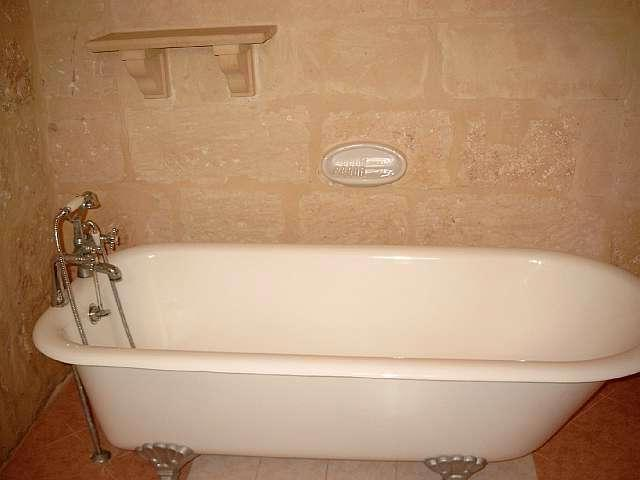

In [26]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

##### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for a couple of epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [27]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - mars, probability - 0.23992469906806946


## Delete Endpoint

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [28]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '4f217a41-f641-4579-b800-0c39c8804f19',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4f217a41-f641-4579-b800-0c39c8804f19',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 20 Nov 2019 20:56:57 GMT'},
  'RetryAttempts': 0}}

## Delete Bucket

In [29]:
res = boto3.resource('s3')
bucket_to_delete = res.Bucket('{}'.format(bucket))
bucket_to_delete.objects.all().delete()
s3.delete_bucket(Bucket=bucket)

{'ResponseMetadata': {'RequestId': 'CAD54F34F9C447E1',
  'HostId': 'q0LXb3SC0F+KdsGpGAj0a2i8dXTJeCXJ9+pnJ3zkg1wxwH+baHHMSkAWLj7XbaCd4hMB3zFtW28=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'q0LXb3SC0F+KdsGpGAj0a2i8dXTJeCXJ9+pnJ3zkg1wxwH+baHHMSkAWLj7XbaCd4hMB3zFtW28=',
   'x-amz-request-id': 'CAD54F34F9C447E1',
   'date': 'Wed, 20 Nov 2019 20:57:03 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}